In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from itertools import groupby

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs


# My imports
import os, sys
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)
               
import utils
import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe
import stats
import time_of_emrgence_calc as toe
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary config/cache directory at /jobfs/112610741.gadi-pbs/matplotlib-jdma4q2r because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [81]:
from enum import Enum

In [2]:
import time_of_emergence.moduls.utils as toe_utils  

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
# Scale the client to have n workers workers
client.cluster.scale(28)
client

- State start
- Found stale lock file and directory '/jobfs/112610741.gadi-pbs/dask-scratch-space/scheduler-bkdus_92', purging
-   Scheduler at:     tcp://127.0.0.1:34763
-   dashboard at:         /proxy/8787/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:43345'
-         Start Nanny at: 'tcp://127.0.0.1:46591'
-         Start Nanny at: 'tcp://127.0.0.1:37911'
-         Start Nanny at: 'tcp://127.0.0.1:45471'
-         Start Nanny at: 'tcp://127.0.0.1:33275'
-         Start Nanny at: 'tcp://127.0.0.1:37267'
-         Start Nanny at: 'tcp://127.0.0.1:34207'
-         Start Nanny at: 'tcp://127.0.0.1:44971'
-         Start Nanny at: 'tcp://127.0.0.1:46159'
-         Start Nanny at: 'tcp://127.0.0.1:43443'
-         Start Nanny at: 'tcp://127.0.0.1:43305'
-         Start Nanny at: 'tcp://127.0.0.1:46043'
-         Start Nanny at: 'tcp://127.0.0.1:46133'
-         Start Nanny at: 'tcp://127.0.0.1:39671'
-         Start Nanny at: 'tcp://127.0.0.1:42153

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34763,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:41467,Total threads: 1
Dashboard: /proxy/40565/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:43345,


In [4]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

In [5]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'
os.listdir(os.path.join(ROOT_DIR, 'best'))

['Land_and_Ocean_LatLong1_time_chunk.zarr',
 'Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [6]:
# chunk_size = {'time': len(best_ds.time.values), 'lat':90, 'lon': 120}  # Chunking in time
# best_ds = best_ds.rename({'latitude':'lat', 'longitude': 'lon|'})
# best_ds = best_ds.chunk(chunk_size)

# best_ds.to_zarr(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1_time_chunk.zarr'), mode='w',
#            encoding={'temperature': {'chunks': (chunk_size['time'], chunk_size['lat'], chunk_size['lon'])}})

In [7]:
best_ds = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1_time_chunk.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)['temperature']

best_ds['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds.time.values))
best_ds = best_ds.resample(time='Y').mean()
best_ds = best_ds.compute()

0.3.0


In [8]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds.where(best_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)>
array([[[  nan, ...,   nan],
        ...,
        [  nan, ...,   nan]],

       ...,

       [[  nan, ...,   nan],
        ...,
        [-0.03, ..., -0.03]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00
Attributes: (5)

In [9]:
base_period_ds_count = base_period_ds.count(dim='time')

In [10]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
data_availability_mask = xr.where(base_period_ds_count>=40, 1, 0)
data_availability_mask

<xarray.DataArray 'temperature' (lat: 180, lon: 360)>
array([[0, ..., 0],
       ...,
       [0, ..., 0]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [11]:
# Apply the mask to both the base period and the full dataset
best_ds = best_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

In [12]:
best_ds = best_ds - base_period_ds.mean(dim='time')

In [13]:
base_period_ds = base_period_ds - base_period_ds.mean(dim='time')

# P-value Methods

1d Array Method <br>

This method comapes starting from the begging and looops through. The nans are added to the end so the length matches

In [14]:
# best_ds = best_ds.sel(lat=slice(-45, -35), lon=slice(135, 160))

In [15]:
# Try with a belt latittude and longitude
# base_period_ds = base_period_ds.sel(lat=slice(-45, -35), lon=slice(135, 160))

In [16]:
window=20

In [17]:
# CHUNKS_FOR_PVALUE_TESTS =  {'lat':60, 'lon':25, 'time':-1}
CHUNKS_FOR_PVALUE_TESTS =  {'lat':30, 'lon':30, 'time':-1}

# {'lat':5, 'lon':5, 'time':-1}

In [18]:
# Creting new datasets that 
best_ds_window = (best_ds
                  .chunk(CHUNKS_FOR_PVALUE_TESTS)
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .persist()) 

base_period_window_ds = (base_period_ds
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist())

In [19]:
best_ds_window

<xarray.DataArray 'temperature' (time: 175, lat: 180, lon: 360, window_dim: 20)>
dask.array<sliding_window_view, shape=(175, 180, 360, 20), dtype=float32, chunksize=(174, 30, 30, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Dimensions without coordinates: window_dim

In [20]:
base_period_window_ds

<xarray.DataArray 'temperature' (window_dim: 50, lat: 180, lon: 360)>
dask.array<xarray-<this-array>, shape=(50, 180, 360), dtype=float32, chunksize=(50, 30, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * window_dim  (window_dim) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00

In [21]:
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [22]:
%%time
ttest_ds = xr.apply_ufunc(
        toe.return_ttest_pvalue,
        best_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 3min 27s, sys: 25.3 s, total: 3min 52s
Wall time: 11min 36s


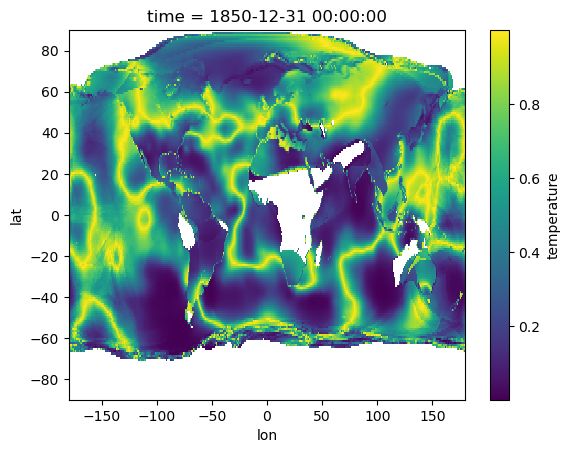

In [23]:
ttest_ds.isel(time=0).plot()

In [24]:
%%time
ks_ds = xr.apply_ufunc(
        toe.return_ks_pvalue,
        best_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 15.9 s, sys: 2.19 s, total: 18.1 s
Wall time: 58.9 s


In [25]:
# ks_2samp will perfom on all nan slices
ks_ds = ks_ds.where(data_availability_mask)

In [26]:
anderson_ds = ks_ds

In [27]:
lat_lon_sp = dict(lat=-39, lon=145, method='nearest')

In [28]:
stats_test_1d_array_ttest = partial(
    toe.stats_test_1d_array, stats_func=toe.return_ttest_pvalue, window=window)

stats_test_1d_array_ks = partial(
    toe.stats_test_1d_array, stats_func=toe.return_ks_pvalue, window=window)

In [29]:
ttest_1d_1p = stats_test_1d_array_ttest(best_ds.sel(**lat_lon_sp))

In [30]:
ks_1d_1p = stats_test_1d_array_ks(best_ds.sel(**lat_lon_sp))

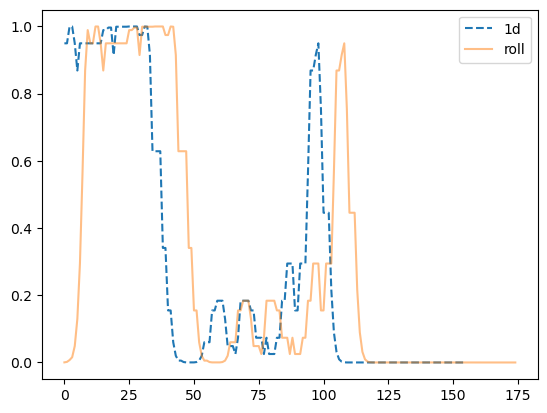

In [31]:
plt.plot(ks_1d_1p,label='1d', linestyle='--')
plt.plot(ks_ds.sel(**lat_lon_sp).values, label='roll', alpha=0.5)
plt.legend()

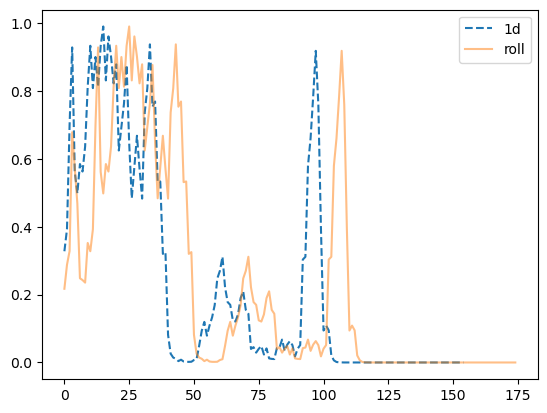

In [32]:
plt.plot(ttest_1d_1p,label='1d', linestyle='--')
plt.plot(ttest_ds.sel(**lat_lon_sp).values, label='roll', alpha=0.5)
plt.legend()

# Signal-to-Noise (hawkins)

In [33]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [34]:
def apply_lowess(arr):
    if all(np.isnan(arr)): return arr

    x = np.arange(arr.shape[0])
    yhat = lowess(arr,x, return_sorted=False)
    return yhat

In [35]:
best_ds_smean = best_ds.clima.space_mean()#.plot()
best_ds_smean

<xarray.DataArray 'temperature' (time: 175)>
array([-0.08, -0.01,  0.04,  0.02,  0.01,  0.03, -0.09, -0.21, -0.04,
        0.08, -0.07, -0.15, -0.22, -0.07, -0.02,  0.06,  0.1 ,  0.12,
        0.11,  0.04,  0.01, -0.  ,  0.02,  0.05, -0.04, -0.02, -0.03,
        0.34,  0.4 ,  0.09,  0.02,  0.12,  0.08,  0.01, -0.14, -0.12,
       -0.15, -0.17,  0.01,  0.13, -0.14,  0.  , -0.09, -0.08, -0.07,
        0.  ,  0.11,  0.09, -0.12,  0.04,  0.15,  0.07, -0.09, -0.18,
       -0.23, -0.04,  0.04, -0.11, -0.16, -0.23, -0.18, -0.2 , -0.12,
       -0.1 ,  0.06,  0.14, -0.08, -0.23, -0.05, -0.04,  0.07,  0.1 ,
        0.01,  0.05,  0.03,  0.09,  0.21,  0.1 ,  0.11, -0.06,  0.17,
        0.21,  0.17, -0.02,  0.13,  0.08,  0.14,  0.29,  0.29,  0.3 ,
        0.35,  0.31,  0.33,  0.4 ,  0.51,  0.38,  0.21,  0.25,  0.2 ,
        0.19,  0.12,  0.29,  0.36,  0.44,  0.24,  0.16,  0.09,  0.32,
        0.34,  0.31,  0.29,  0.34,  0.31,  0.33,  0.08,  0.18,  0.22,
        0.24,  0.19,  0.32,  0.26,  0.14,  0.24,  0.39,  0.18,  0.27,
        0.17,  0.49,  0.36,  0.46,  0.53,  0.6 ,  0.42,  0.58,  0.39,
        0.41,  0.46,  0.59,  0.62,  0.55,  0.71,  0.67,  0.5 ,  0.57,
        0.63,  0.76,  0.61,  0.81,  0.93,  0.72,  0.7 ,  0.84,  0.89,
        0.9 ,  0.83,  0.95,  0.92,  0.89,  0.81,  0.91,  1.  ,  0.87,
        0.93,  0.94,  1.02,  1.2 ,  1.28,  1.19,  1.09,  1.22,  1.27,
        1.14,  1.16,  1.47,  1.63], dtype=float32)
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

In [36]:
best_ds_smean_lowess = xr.zeros_like(best_ds_smean) + apply_lowess(best_ds_smean.values)

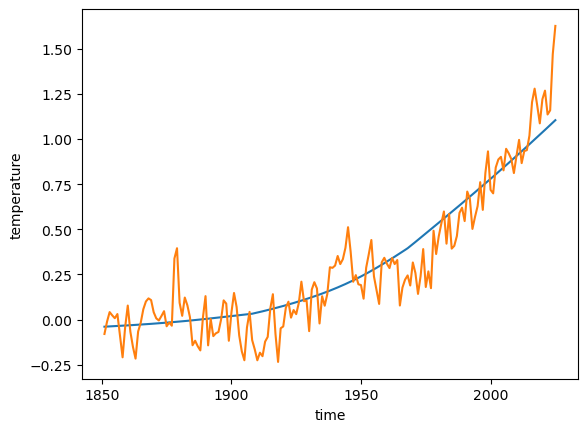

In [37]:
best_ds_smean_lowess.plot()
best_ds_smean.plot()

In [38]:
return_hawkins_signal_and_noise_partial = partial(toe.return_hawkins_signal_and_noise, gt=best_ds_smean_lowess.values)

In [39]:
signal_sp, noise_series_sp, reocnstructed_sp =\
    return_hawkins_signal_and_noise_partial(
        best_ds.sel(lat=-14, lon=-115, method='nearest').values,
        return_reconstruction=True)

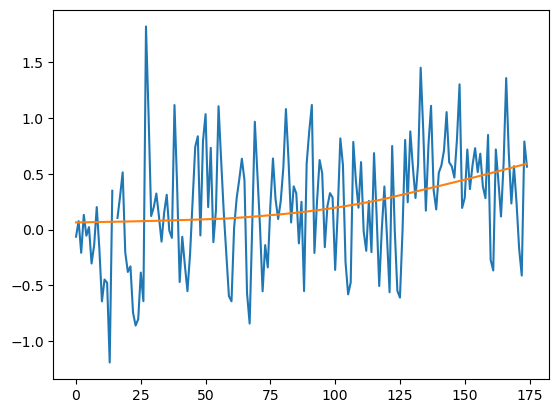

In [40]:
plt.plot(best_ds.sel(lat=-14, lon=-115, method='nearest').values)
plt.plot(reocnstructed_sp)

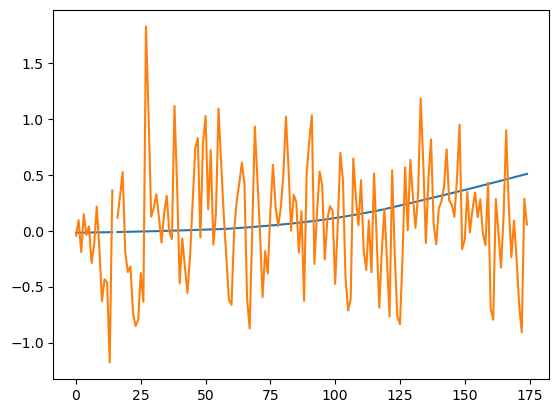

In [41]:
plt.plot(signal_sp)
plt.plot(noise_series_sp)

In [42]:
ds_best_signal, ds_best_noise_series = xr.apply_ufunc(
    return_hawkins_signal_and_noise_partial,
    best_ds,
    input_core_dims=[['time']], 
    output_core_dims=[['time'], ['time']], 
    dask='parallelized', 
    vectorize=True
)

- Event loop was unresponsive in Nanny for 5.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 6.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


In [43]:
ds_best_noise = ds_best_noise_series.std(dim='time')

- Event loop was unresponsive in Nanny for 8.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 8.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 8.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 8.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 8.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 8.05s.  This is often caused by long-runni

In [44]:
ds_best_sn = ds_best_signal/ds_best_noise

- Event loop was unresponsive in Nanny for 8.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 8.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 8.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 8.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Scheduler for 8.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 8.08s.  This is often caused by long-r

In [45]:
sel_dict = dict(lat=-38, lon=144, method='nearest')

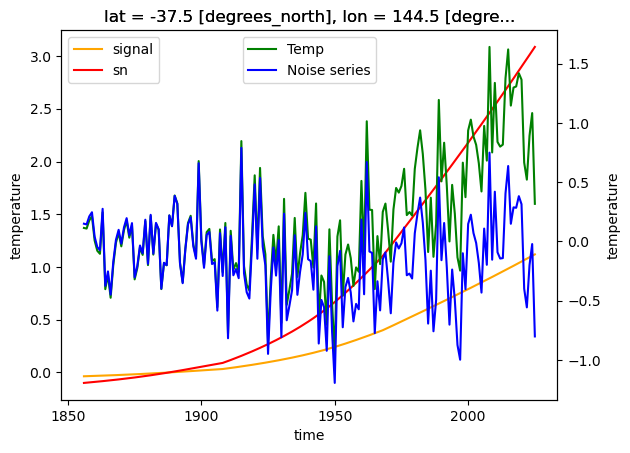

In [46]:
fig, ax1 = plt.subplots(1, 1)
ax2 = ax1.twinx()
ds_best_signal.sel(**sel_dict).plot(ax=ax1, label='signal', color='orange')
ds_best_sn.sel(**sel_dict).plot(ax=ax1, label='sn', color='red')

best_ds.sel(**sel_dict).plot(ax=ax2, label='Temp', color='green')
ds_best_noise_series.sel(**sel_dict).plot(ax=ax2, color='blue', label='Noise series')

ax1.legend()
ax2.legend(loc='upper center')

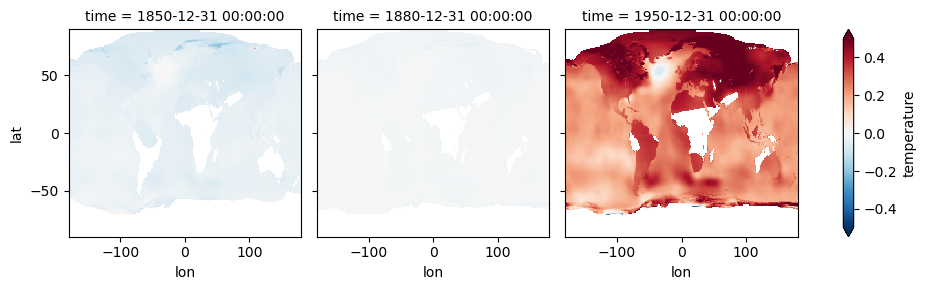

In [47]:
ds_best_signal.isel(time=[0, 30, 100]).plot(col='time', robust=True)

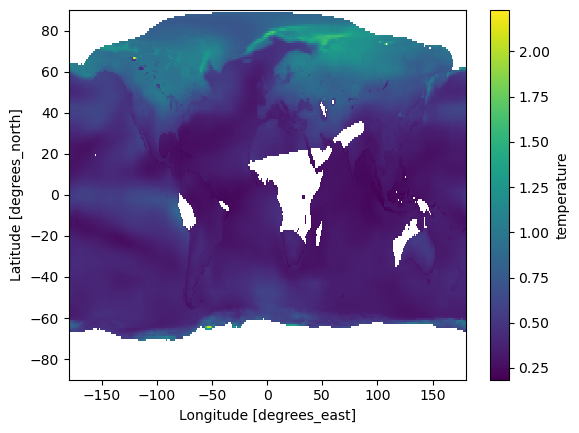

In [48]:
ds_best_noise.plot()

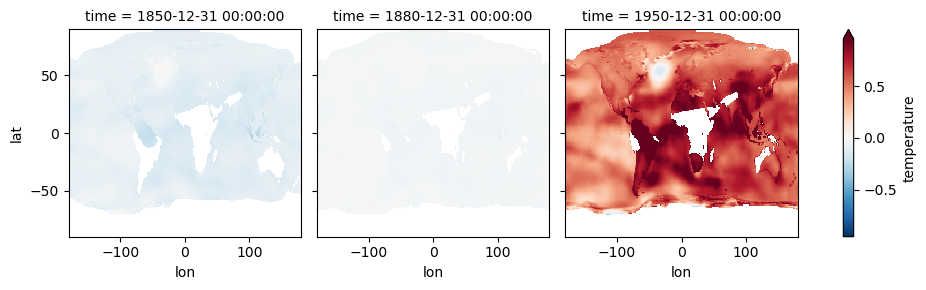

In [49]:
ds_best_sn.isel(time=[0, 30, 100]).plot(col='time', robust=True)

# Emergence Calculation

In [50]:
PVALUE_THESHOLD1 = 0.01

# Finding when each test does not emerge
sn_does_not_emerge = (ds_best_sn.isel(time=-1) <= 2)

ks_does_not_emerge = (ks_ds.isel(time=-1) >= PVALUE_THESHOLD1)

ttest_does_not_emerge = (ttest_ds.isel(time=-1) >= PVALUE_THESHOLD1)

anderson_does_not_emerge = (anderson_ds.isel(time=-1) >= PVALUE_THESHOLD1)

In [51]:
# Find the year of permanent exceedance
sn_toe_ds = toe.get_permanent_exceedance(ds_best_sn, threshold=2, comparison_func=np.greater_equal)

ks_toe_ds = toe.get_permanent_exceedance(ks_ds, threshold=PVALUE_THESHOLD1, comparison_func=np.less)

ttest_toe_ds = toe.get_permanent_exceedance(ttest_ds, threshold=PVALUE_THESHOLD1, comparison_func=np.less)

anderson_toe_ds = toe.get_permanent_exceedance(anderson_ds, threshold=PVALUE_THESHOLD1, comparison_func=np.less)

- Event loop was unresponsive in Nanny for 8.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 8.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 8.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 8.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


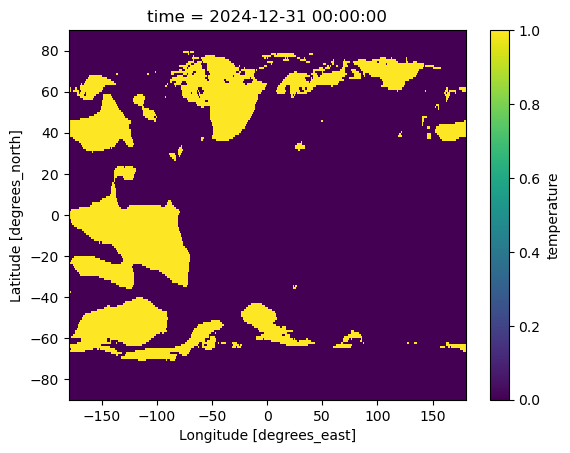

In [52]:
(ds_best_sn.isel(time=-1) <= 2).plot()

# Explorign Odd Patterns

In [53]:
time_indices = np.array([0, 50, 100, 150])

- Event loop was unresponsive in Nanny for 7.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.53s.  This is often caused by long-runni

- Event loop was unresponsive in Nanny for 7.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 7.61s.  This is often caused by long-runni

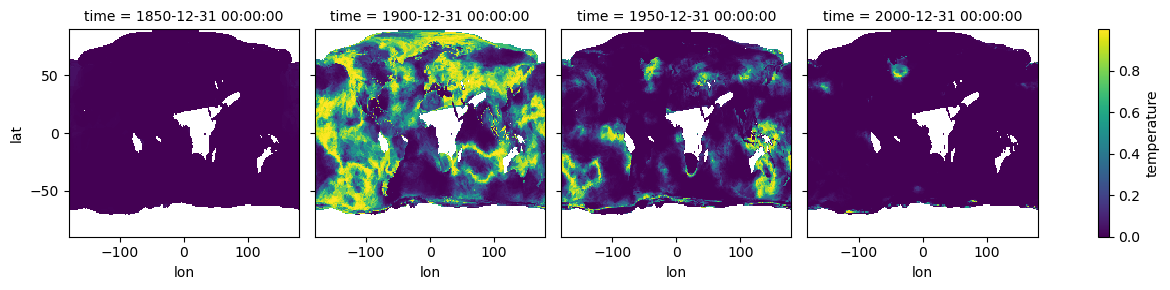

In [54]:
ks_ds.isel(time=time_indices).plot(col='time')

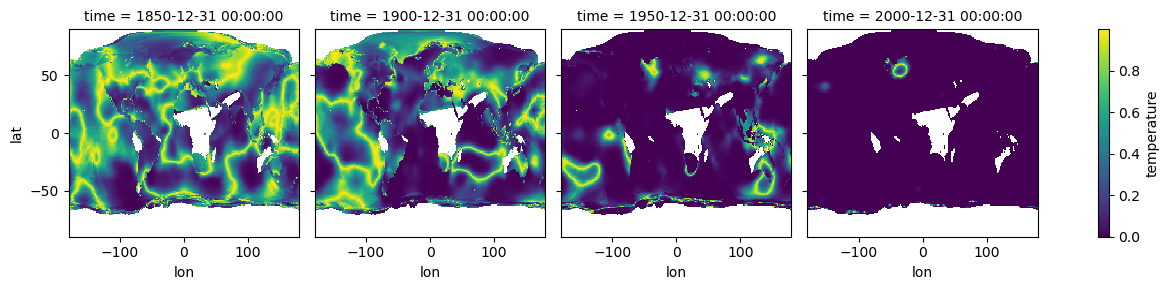

In [55]:
ttest_ds.isel(time=time_indices).plot(col='time')

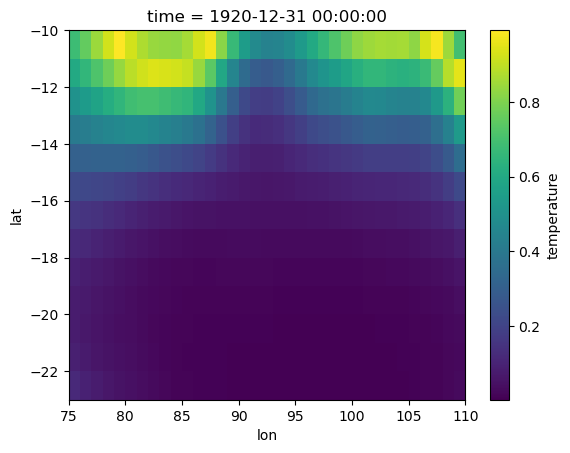

In [56]:
test_sample_ds = ttest_ds.isel(time=70).sel(lat=slice(-22.5, -10), lon=slice(75, 110))
test_sample_ds.plot()

In [57]:
# Get the lat and lon with the minimum value
min_lat, min_lon = toe_utils.find_nth_extreme_location(test_sample_ds, 'min')
min_lat, min_lon

(-22.5, 98.5)

In [58]:
# Get the lat and lon with the maximum value
max_lat, max_lon = toe_utils.find_nth_extreme_location(test_sample_ds, 'max')
max_lat, max_lon

(-10.5, 107.5)

In [59]:
min_time_series = best_ds.sel(lat=min_lat, lon=min_lon)
max_time_series = best_ds.sel(lat=max_lat, lon=max_lon)

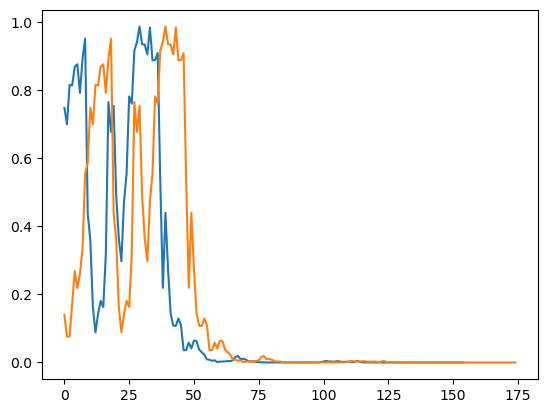

In [61]:
plt.plot(toe.stats_test_1d_array(min_time_series, stats_func=toe.return_ttest_pvalue))
plt.plot(ttest_ds.sel(lat=min_lat, lon=min_lon).values)

In [62]:
min_series_pvals = xr.zeros_like(min_time_series) + toe.stats_test_1d_array(min_time_series, stats_func=toe.return_ttest_pvalue)
max_series_pvals = xr.zeros_like(max_time_series) + toe.stats_test_1d_array(max_time_series, stats_func=toe.return_ttest_pvalue)

In [63]:
def color_yaxis(axis, color, side='left'):
    if not isinstance(axis, list): axis = [axis]
    for ax in axis:
        ax.spines[side].set_color(color)
        ax.tick_params(axis='y', color=color, labelcolor=color)

Text(0, 0.5, 'Temperature\nAnomaly')

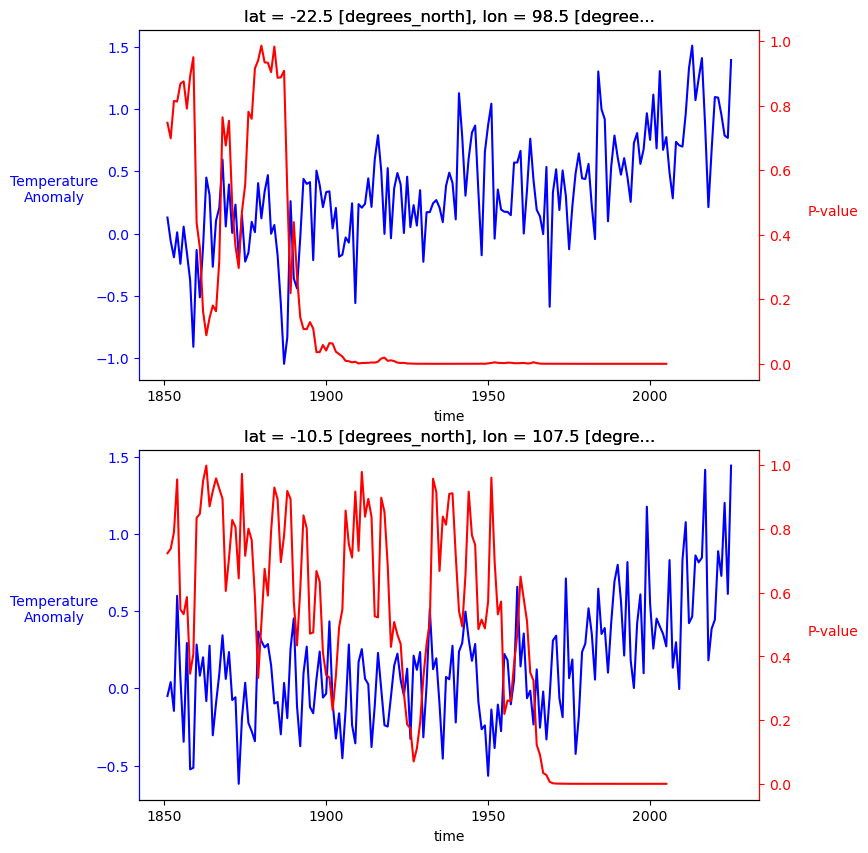

In [64]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 10), nrows=2, ncols=1)

ax1_twinx = ax1.twinx()
min_time_series.plot(ax=ax1, color='blue')
min_series_pvals.plot(ax=ax1_twinx, color='red')
color_yaxis([ax1, ax1_twinx], 'blue', 'left')
color_yaxis([ax1_twinx], 'red', 'right')
ax1_twinx.set_ylabel('P-value', c='red', rotation=0, labelpad=30)
ax1.set_ylabel('Temperature\nAnomaly', c='blue', rotation=0, labelpad=30)

ax2_twinx = ax2.twinx()
max_time_series.plot(ax=ax2, color='blue')
max_series_pvals.plot(ax=ax2_twinx, color='red')
color_yaxis([ax2, ax2_twinx], 'blue', 'left')
color_yaxis([ax2_twinx], 'red', 'right')
ax2_twinx.set_ylabel('P-value', c='red', rotation=0, labelpad=30)
ax2.set_ylabel('Temperature\nAnomaly', c='blue', rotation=0, labelpad=30)

# Plotting

In [67]:
grey_white_cmap = mcolors.LinearSegmentedColormap.from_list('grey_white_cmap',  [(1, 1, 1), (0.5, 0.5, 0.5)] , N=2)

In [68]:
not_stable_kwargs = dict(add_colorbar=False, hatches=['', '////'], alpha=0, colors=None)

not_stable_kwargs2 = dict(cmap= grey_white_cmap, add_colorbar=False)

Text(0.5, 1.0, 'Anderson')

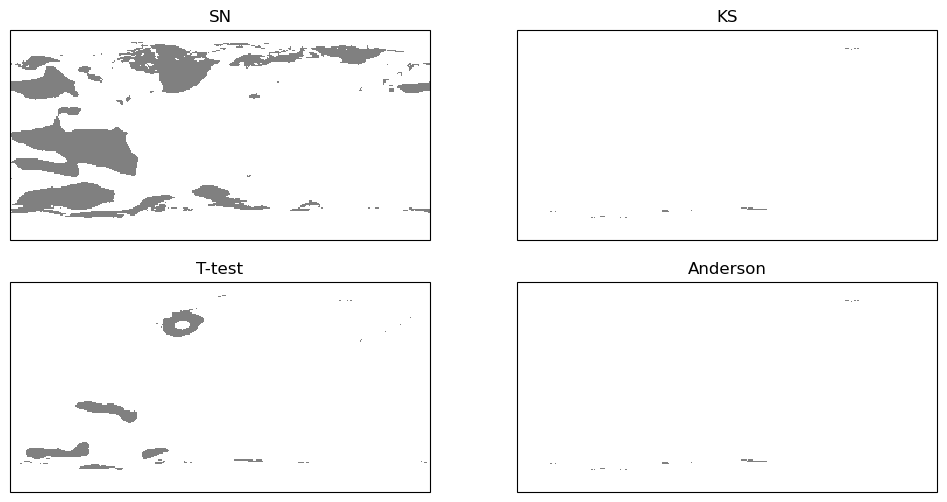

In [69]:
fig = plt.figure(figsize=(12, 6))
axes = [fig.add_subplot(2,2,i, projection=ccrs.PlateCarree()) for i in range(1,5)]

sn_does_not_emerge.plot(ax=axes[0], **not_stable_kwargs2)
ks_does_not_emerge.plot(ax=axes[1], **not_stable_kwargs2)
ttest_does_not_emerge.plot(ax=axes[2], **not_stable_kwargs2)
anderson_does_not_emerge.plot(ax=axes[3], **not_stable_kwargs2)
axes[0].set_title('SN')
axes[1].set_title('KS')
axes[2].set_title('T-test')
axes[3].set_title('Anderson')

In [70]:
def hatch(ax, ds, **kwargs):
    LON, LAT = np.meshgrid(ds.lon.values, ds.lat.values)
    ax.contourf(LON, LAT, ds.values, **kwargs)

In [71]:
not_stable_kwargs = dict(add_colorbar=False, hatches=['', '////'], alpha=0, colors=None)

In [72]:
data_unavailability_mask = xr.where(data_availability_mask, False, True)

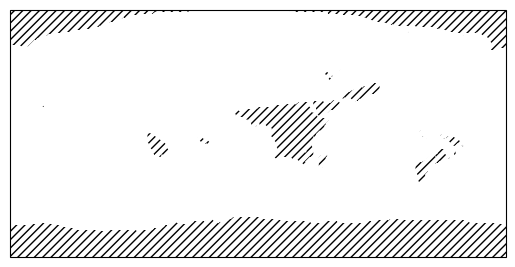

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
hatch(ax, xr.where(data_availability_mask, False, True), **not_stable_kwargs)

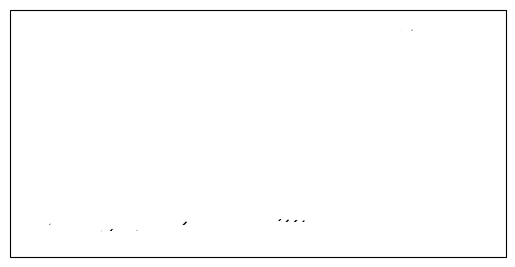

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
hatch(ax, ks_does_not_emerge, **not_stable_kwargs)

In [75]:
from scipy.stats import spearmanr

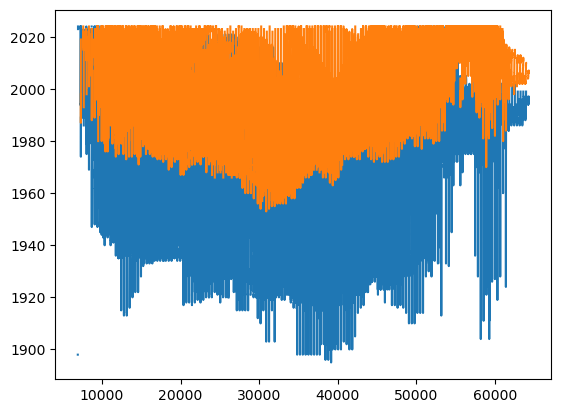

In [76]:
plt.plot(ks_toe_ds.values.flatten())
plt.plot(sn_toe_ds.values.flatten())

In [77]:
spearmanr(ks_toe_ds.values.flatten(), sn_toe_ds.values.flatten(), nan_policy='omit').statistic

0.568553440512136

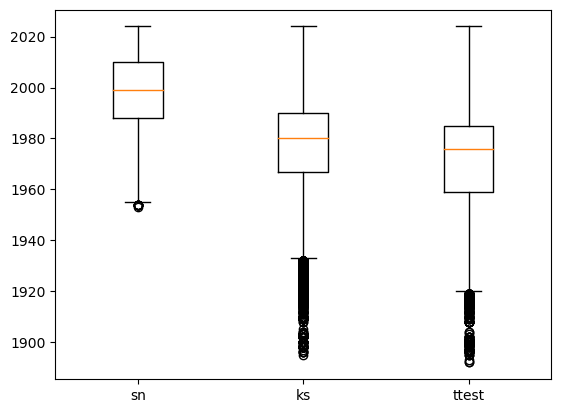

In [78]:
fig, ax = plt.subplots()

bins = np.arange(1900, 2025, 5)
ax.boxplot([sn_toe_ds.stack(latlon=['lat', 'lon']).dropna(dim='latlon').values.flatten(), 
            ks_toe_ds.stack(latlon=['lat', 'lon']).dropna(dim='latlon').values.flatten(),
            ttest_toe_ds.stack(latlon=['lat', 'lon']).dropna(dim='latlon').values.flatten()],
          labels=['sn', 'ks', 'ttest']);

Text(0.5, 1.0, 'T-test')

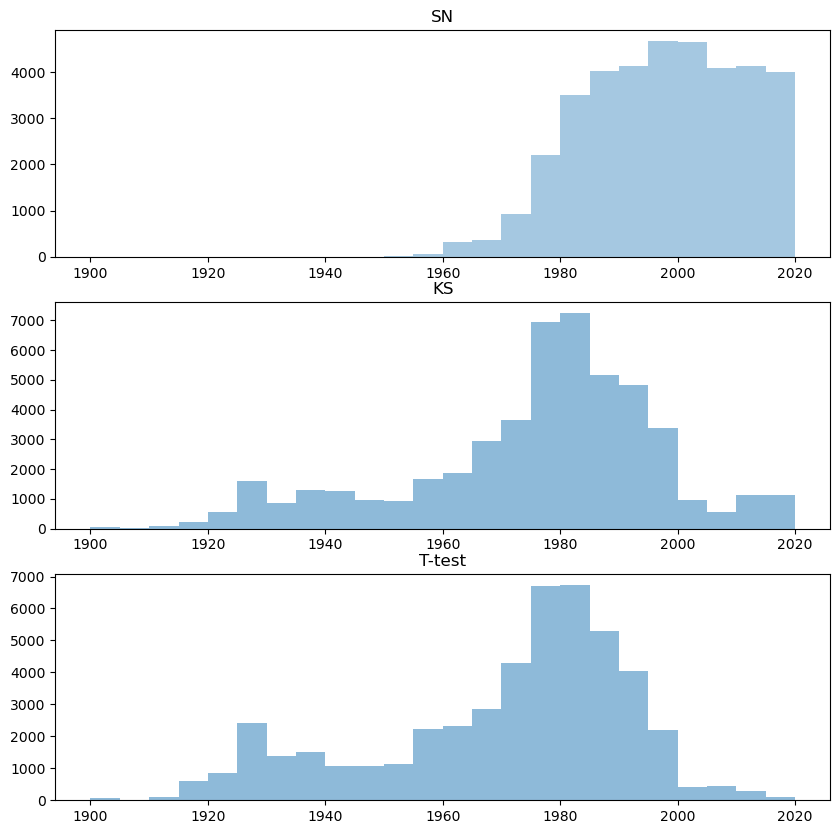

In [79]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

bins = np.arange(1900, 2025, 5)
ax1.hist(sn_toe_ds.values.flatten(), bins=bins, alpha=0.4, label='sn')
ax2.hist(ks_toe_ds.values.flatten(), bins=bins, alpha=0.5, label='ks')
ax3.hist(ttest_toe_ds.values.flatten(), bins=bins, alpha=0.5, label='ttest')

ax1.set_title('SN')
ax2.set_title('KS')
ax3.set_title('T-test')

In [80]:
difference_sn_ks_ds = sn_toe_ds - ks_toe_ds

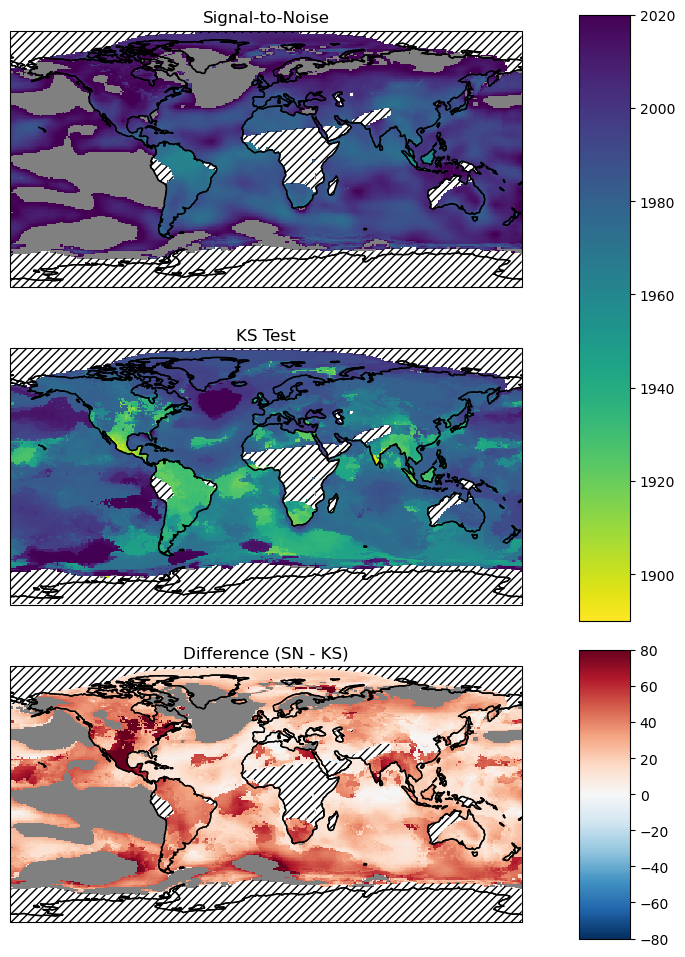

In [84]:
fig = plt.figure(figsize=(8, 12))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(3, 2, width_ratios=[1, 0.1], hspace=0.1)
axes = [fig.add_subplot(gs[i, 0], projection=projection) for i in range(3)]

toe_plot_kwargs = dict(cmap='viridis_r',add_colorbar=False, vmin=1890, vmax=2020)

sn_does_not_emerge.plot(ax=axes[0], **not_stable_kwargs2)
ks_does_not_emerge.plot(ax=axes[1], **not_stable_kwargs2)
(ks_does_not_emerge | sn_does_not_emerge).plot(ax=axes[2], **not_stable_kwargs2)

sn_toe_ds.plot(ax=axes[0], **toe_plot_kwargs)
toe_plot = ks_toe_ds.plot(ax=axes[1], **toe_plot_kwargs)

cbar_axes1 = plt.subplot(gs[:2, 1])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='vertical')

diff_plot = difference_sn_ks_ds.plot(ax=axes[2], add_colorbar=False, vmin=-80, vmax=80, cmap='RdBu_r')

cbar_axes2 = plt.subplot(gs[2, 1])
cbar2 = plt.colorbar(diff_plot, cax=cbar_axes2, orientation='vertical')

for ax in axes: ax.coastlines()

axes[0].set_title('Signal-to-Noise')
axes[1].set_title('KS Test')
axes[2].set_title('Difference (SN - KS)')

for ax in axes:
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)


In [85]:
class LocationBoxes(Enum):
    NORTH_AMERICA = dict(lat=slice(10, 66), lon=slice(-160, -49))

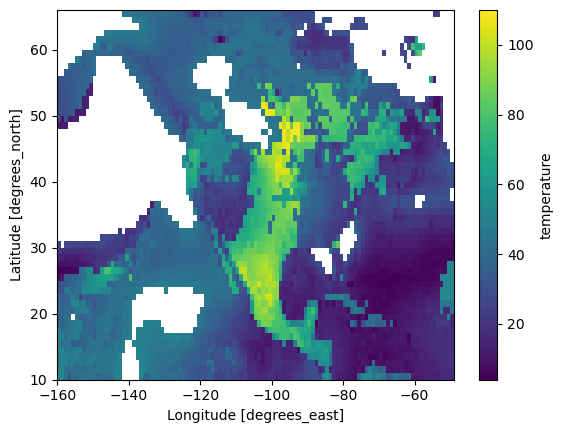

In [83]:
difference_sn_ks_ds.sel(LocationBoxes.NORTH_AMERICA.value).plot()

In [88]:
difference_sn_ks_ds.sel(LocationBoxes.NORTH_AMERICA.value).values.flatten()

array([53., ..., nan])

In [101]:
reload(toe_utils)

<module 'time_of_emergence.moduls.utils' from '/home/563/ab2313/Documents/PhD/time_of_emergence/moduls/utils.py'>

In [103]:
na_lat_lon =\
    toe_utils.find_nth_extreme_location(
        difference_sn_ks_ds.sel(LocationBoxes.NORTH_AMERICA.value), 'max',
    output_dtype='dict')
na_lat_lon

{'lat': 46.5, 'lon': -95.5}

In [ ]:
from typing import Dict
from numpy.typing import ArrayLike

In [122]:
series_dict = {
    'ks':ks_ds.sel(**na_lat_lon, method='nearest').values,
    'ttest': ks_ds.sel(**na_lat_lon, method='nearest').values,
    'anderson': anderson_ds.sel(**na_lat_lon, method='nearest').values,  
}

In [ ]:
exceedance_dict_w_plot_coords

In [119]:
def plot_multiseries_with_pvalues(series_dict:Dict[str, ArrayLike], 
                                  exceedance_dict_w_plot_coords:Dict[str, float], best_ds_smean):
    fig, ax_base = plt.subplots()
    ax1 = ax_base.twinx()  # p-value tests
    ax2 = ax_base.twinx()  # SN

    legend_lines = []  # For storing lines for the legend

    for series_name, series_data in series_dict.items():
        if series_name in ['ks', 'ttest', 'anderson']:
            ax = ax1
            color = 'red' if series_name == 'ks' else 'orange' if series_name == 'ttest' else 'sienna'
            label = series_name.capitalize()  # Use series name as label
            ax.plot(series_data.time.values, flip_pvalue(series_data.to_numpy()), c=color, label=label)
            legend_lines.append(ax.plot([], [], color=color, label=label)[0])
        elif series_name == 'best_sn':
            ax = ax2
            series_data.plot(ax=ax, c='blue')
            legend_lines.append(ax.plot([], [], color='blue', label='Signal-to-Noise')[0])

    for ax, color in zip([ax1, ax2], ['red', 'blue']):
        ax.spines['right'].set_color(color)
        ax.tick_params(axis='y', color=color, labelcolor=color)

    for test_name, dobj in exceedance_dict_w_plot_coords.items():
        color = TEST_COLOR_DICT.get(test_name, 'black')  # Get color from dict or default to black
        ax = ax2 if test_name == 'sn' else ax1
        val = dobj['val'] if test_name == 'sn' else flip_pvalue(dobj['val'])
        ax.scatter(dobj['year_datetime'], val, color=color)

    ax1.set_ylim(-0.1, 1.1)

    plotting_functions.match_ticks(ax1, ax2)
    ax1.set_yticklabels([label.get_text() for label in ax1.get_yticklabels()][::-1])

    ax1.set_ylabel('p-value', color='red')
    ax2.set_ylabel('Signal-to-Noise Ratio', color='blue')

    ax2.spines['right'].set_position(('outward', 60))

    best_ds_smean.plot(ax=ax_base)
    ax_base.set_ylabel('GMST Anomaly (K)')

    ax1.grid(True)
    ax_base.grid(True, axis='x')

    # Create the legend
    legend = ax_base.legend(ncol=len(legend_lines), handles=legend_lines, loc='center', bbox_to_anchor=(0.5, 0.95), frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')  # Set the legend frame color to white
    frame.set_edgecolor('black')  # Set the legend frame edge color to black

    # Move the legend to the left side
    ax_base.add_artist(legend)

    ax_base.set_xlabel('Time')


In [ ]:
fig, ax_base = plt.subplots()
ax1 = ax_base.twinx() # p-value tests
ax2 = ax_base.twinx() # SN

ax1.plot(ks_ds.time.values, flip_pvalue(ks_ds.to_numpy()), c='red', label='ks')
ax1.plot(ttest_ds.time.values, flip_pvalue(ttest_ds.to_numpy()), c='orange', label='T-Test')
ax1.plot(anderson_ds.time.values, flip_pvalue(anderson_ds.to_numpy()), c='sienna', label='anderson darling')
ds_best_sn.plot(ax=ax2, c='blue')

for ax, color in zip([ax1, ax2],['red', 'blue']):
    ax.spines['right'].set_color(color)
    ax.tick_params(axis='y', color=color, labelcolor=color)


ax1.axhline(0.99, linestyle='--', color='red', alpha=0.25, linewidth=0.8)
ax2.axhline(2, linestyle='--', color='blue', alpha=0.25, linewidth=1.5)


for test_name, dobj in exceedance_dict_w_plot_coords.items():
    color = TEST_COLOR_DICT[test_name]
    if test_name == 'sn': ax=ax2; val = dobj['val']
    else: ax=ax1; val = flip_pvalue(dobj['val'])
    ax.scatter(dobj['year_datetime'], val, color=color)



ax1.set_ylim(-0.1, 1.1)

plotting_functions.match_ticks(ax1, ax2)
ax1.set_yticklabels([label.get_text() for label in ax1.get_yticklabels()][::-1])

ax1.set_ylabel('p-value', color='red')
ax2.set_ylabel('Signal-to-Noise Ratio', color='blue')

ax2.spines['right'].set_position(('outward', 60))

best_ds_smean.plot(ax=ax_base)
ax_base.set_ylabel('GMST Anomaly (K)')

ax1.grid(True)
ax_base.grid(True, axis='x')



# Define the lines and labels for the legend
legend_lines = [
    ax1.plot([], [], color='red', label='KS')[0],
    ax1.plot([], [], color='orange', label='T-Test')[0],
    ax1.plot([], [], color='sienna', label='Anderson Darling')[0],
    ax2.plot([], [], color='blue', label='Signal-to-Noise')[0]
]

# Create the legend
legend = ax_base.legend(ncol=4, handles=legend_lines, loc='center', bbox_to_anchor=(0.5, 0.95), frameon=True)
frame = legend.get_frame()
frame.set_color('white')  # Set the legend frame color to white
frame.set_edgecolor('black')  # Set the legend frame edge color to black

# Move the legend to the left side
ax_base.add_artist(legend)

ax_base.set_xlabel('Time')

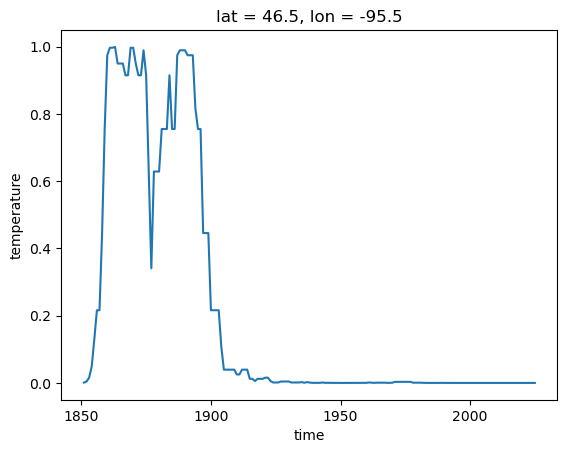

In [105]:
fig
ks_ds.sel(**na_lat_lon, method='nearest').plot()